# Agent 3

Develop the code for an agent that emulates the intuitive policy of:  *Turn up the heat really hot, then turn it down low to accelerate the heating of the griddle*

In [2]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import random
import os
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import GridSimulator

## Develop the methodology of hot then cold

This agent is supposed to turn up the *hot side* to a specific temperature (`temperatureHot`) for a specific amount of time (`timeHot`).  After that time, turn the temperature down to a specific temperature (`temperatureCold`) and complete the simulation and score the results

In [202]:
class ClassAgent3: 

    
    def temperatureProfile(self, timeAssess):
        temperatureResult = self.temperatureCold
        if(timeAssess < self.timeHot):
            temperatureResult = self.temperatureHot
        return temperatureResult
    
    def runSimulation(self, timeTotal, timeHot, temperatureHot, temperatureCold, objHeatSimulator):
        score = 0
        
        # run simulation with temperature profile
        
        dTimeRecommend = objHeatSimulator.SuggestedTimeInc(True)
        
        # run the simulator for the hot temperature for a duration of hot time
        timeStart = 0
        timeEnd = timeHot
        noStepsMin =( timeEnd - timeStart)/dTimeRecommend
        noSteps = int(np.ceil(noStepsMin*1.2))
        timeSequence = np.linspace(timeStart, timeEnd, noSteps)
        dTimeLinspace = timeSequence[1] - timeSequence[0]

        objHeatSimulator.TimeInc = dTimeLinspace
        objHeatSimulator.SetHeatSource(temperatureHot)
        objHeatSimulator.CreateDF()
        objHeatSimulator.AdvanceSimulationByTime(timeHot, temperatureHot)
        
        # run the simulator for the cold temperature until the end of the total time
        timeStart = timeHot
        timeEnd = timeTotal
        noStepsMin =( timeEnd - timeStart)/dTimeRecommend
        noSteps = int(np.ceil(noStepsMin*1.2))
        timeSequence = np.linspace(timeStart, timeEnd, noSteps)
        dTimeLinspace = timeSequence[1] - timeSequence[0]

        objHeatSimulator.TimeInc = dTimeLinspace

        objHeatSimulator.SetHeatSource(temperatureCold)
        objHeatSimulator.AdvanceSimulationByTime((timeTotal-timeHot), temperatureCold)

        #Evaluate the score of the simulation
        self.objHeatSimulator = objHeatSimulator
        
        isTemperatureGoodForCooking = (objHeatSimulator.AllTemp.Node10 > 100) & \
            (objHeatSimulator.AllTemp.Node10 < 135)
        
        scoreOverTime = -np.ones(isTemperatureGoodForCooking.shape)
        scoreOverTime[isTemperatureGoodForCooking] = 1.0
        
        scoreIntegral = np.trapz(scoreOverTime, objHeatSimulator.AllTemp.Time.to_numpy())
        score = scoreIntegral / np.max(objHeatSimulator.AllTemp.Time)
        
        return score
    

#  Test the Agent Class

Make sure that temperature vs. time looks right for the heater and the simulator

In [203]:
class Agent3(Env):
    
    def __init__(self):
        print("Init Agent3")

        self.objHeatSimulator = GridSimulator.ClassHeatSimulation()
        self.objAgent = ClassAgent3()
        self.reset()
        # space (x3) discretes:  one for time, tempHot, tempCold
        self.action_space = MultiDiscrete([ 9, 3, 3 ])
        
        self.listTemperatureHot = np.array([200, 300, 400, 500])
        self.listTemperatureCold = np.array([100, 125, 150, 175])
        self.listTimeHot = np.array([30, 60, 90, 120, 150, 180, 210, 240, 270, 300])*10
        
        self.observation_space = Box(low=-2, high=2, shape=(1,))

        self.timeTotal = 3600

        self.state = 0
        self.stepCurrent = 0
        
    def step(self, action):
        #  An action is to run the entire simulation with the (x3) parameters that are chosen
        timeHot = self.listTimeHot[action[0]]
        temperatureHot = self.listTemperatureHot[action[1]]
        temperatureCold = self.listTemperatureCold[action[2]]
        
        self.stepCurrent += 1
            
        print("....Start step: " + str(self.stepCurrent))
        score = self.objAgent.runSimulation(self.timeTotal, timeHot, temperatureHot, temperatureCold, self.objHeatSimulator)

        self.state = score
        reward = score
        print("....Done")
        done = True
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        pass
    
    def reset(self):
        self.state = 0
        
        numberNodes = 10
        thicknessTotal = 0.1
        widthBar = 0.003
        thicknessBar = 0.003

        materialDensity = 7800
        materialSpecificHeat = 500
        materialThermalConductivity = 16.2

        convectionCoefficient = 4
        convectionTemperature = 25

        temperatureHeatSource = 25
        temperatureInitialIsothermal = 25
        doesSurfaceTemperatureAllowConvection = False

        self.objHeatSimulator.SetSize(widthBar,thicknessBar)
        self.objHeatSimulator.SetNodes(numberNodes,thicknessTotal)
        self.objHeatSimulator.SetMaterialProperties(materialDensity,materialSpecificHeat,materialThermalConductivity)
        self.objHeatSimulator.SetConvectionProperties(convectionCoefficient,convectionTemperature)
        self.objHeatSimulator.EnableSurfaceHeatTransfer(doesSurfaceTemperatureAllowConvection)
        self.objHeatSimulator.SetHeatSource(temperatureHeatSource)
        self.objHeatSimulator.SetInitalTemp(temperatureInitialIsothermal)
        self.objHeatSimulator.UpdatePropertiesTable()
        
        self.objAgent = ClassAgent3()
        self.stepCurrent = 0
        print("..Reset")

        return self.state

In [204]:
env = Agent3()

Init Agent3
..Reset


One episode being tested

..Reset
....Start step: 1
....Done
Episode:1 Score:-0.7662337662337678


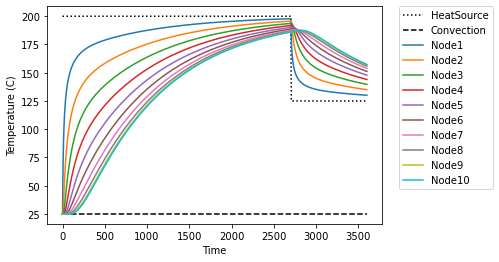

..Reset
....Start step: 1
....Done
Episode:2 Score:0.6175516224188774


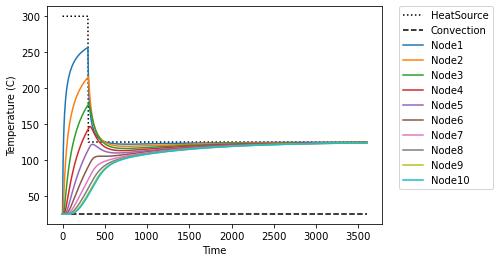

..Reset
....Start step: 1
....Done
Episode:3 Score:-0.6118911878723514


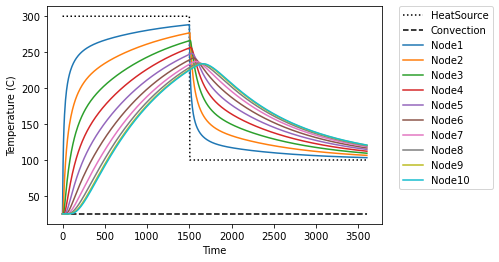

..Reset
....Start step: 1
....Done
Episode:4 Score:-0.5438311688311689


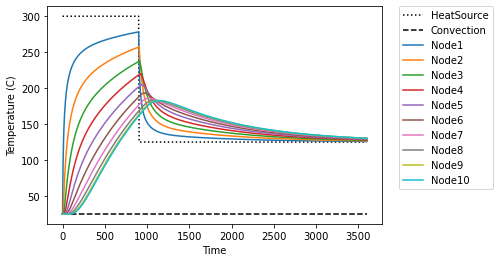

In [205]:
episodes = 4
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    #print(score)
    print('Episode:{} Score:{}'.format(episode, score))
    env.objAgent.objHeatSimulator.GraphResults("")
env.close()

The Machine Learner

**Debuged verison to be put in new notebook**

In [206]:
log_path = os.path.join('Training', 'Logs', 'Agent3')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Set number of "steps", steps are the same as number of episodes, each episode is fairly quick

In [207]:
TrainningSteps = 1

In [213]:
model.learn(total_timesteps=1)

TypeError: learn() got an unexpected keyword argument 'progress_bar'

In [186]:
!tensorboard --logdir={log_path}

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.10.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


..Reset
....Start
....Done
Score: -0.8443316412859568


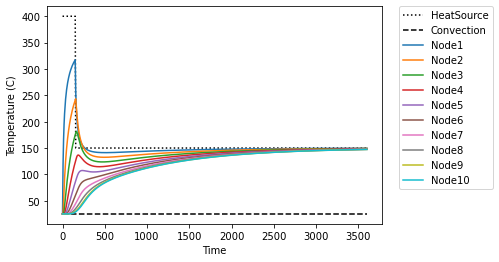

In [58]:
obs = env.reset()
action, _states = model.predict((obs,))
obs, rewards, done, info = env.step(action)
score+=rewards
print('Score: ' + str(rewards))
env.objHeatSimulator.GraphResults("")
env.close()

In [184]:
obs = env.reset()
action, _states = model.predict((obs,))
print("Observations: " + str(obs))
print("Actions: " + str(action))
print("States: " + str(_states))

..Reset
Observations: 0
Actions: [4 2 1]
States: None


In [51]:
env.objAgent.runSimulation(3600, 500, 200, 160, env.objAgent.objHeatSimulator)

-0.9026993094789699